In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as req
from bs4 import BeautifulSoup as bs
from selenium import webdriver as wb
from selenium.webdriver.common.keys import Keys
import time 
h = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36"}
import os 
from urllib.request import urlretrieve
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

### 문제정의 (목표)

- 500명의 키와 몸무게, 성별 데이터를 가지고 비만도 라벨(label)을 이용해 비만을 판단하는 모델을 만들어보자

### 데이터 수집 (데이터를 로드)

In [2]:
# 상대경로를 통해서 data 폴더에 있는 bmi_500.csv 파일을
# 불러와서 Label이라는 컬럼을 인덱스 열 설정
bmi = pd.read_csv('data/bmi_500.csv', index_col='Label')

In [3]:
bmi

,Gender,Height,Weight
Label,,,
Obesity,Male,174,96
Normal,Male,189,87
Obesity,Female,185,110
Overweight,Female,195,104
Overweight,Male,149,61
...,...,...,...
Extreme Obesity,Female,150,153
Obesity,Female,184,121
Extreme Obesity,Female,141,136


### 데이터 전처리: 전처리가 필요없는 데이터임 -> 따로 필요가 없다

### 탐색적 데이터 분석

In [4]:
bmi.loc['Normal']

,Gender,Height,Weight
Label,,,
Normal,Male,189,87
Normal,Male,195,81
Normal,Male,155,51
Normal,Male,191,79
Normal,Female,172,67
...,...,...,...
Normal,Female,178,65
Normal,Male,167,64
Normal,Female,151,55


In [5]:
# 전체 행의 수, 결측치가 없는 행의 수, 컬럼별 데이터 타입
# object: 범주형, int64: 수치형 (정수), float64: 수치형 (실수)
bmi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, Obesity to Extreme Obesity
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  500 non-null    object
 1   Height  500 non-null    int64 
 2   Weight  500 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 25.6+ KB


In [6]:
# 기술통계를 확인
bmi.describe()

,Height,Weight
count,500.000000,500.000000
mean,169.944000,106.000000
std,16.375261,32.382607
min,140.000000,50.000000
25%,156.000000,80.000000
50%,170.500000,106.000000
75%,184.000000,136.000000
max,199.000000,160.000000


In [7]:
# index로 설정된 열의 데이터의 유니크 값을 출력
bmi.index.unique()

Index(['Obesity', 'Normal', 'Overweight', 'Extreme Obesity', 'Weak',
       'Extremely Weak'],
      dtype='object', name='Label')

- 각 비만도 등급별로 시각화

In [8]:
# 선점도를 표시하는 함수를 만들어보자!
def myscatter (label, color):
    # 원하는 레이블 값을 인덱싱
    tmp = bmi.loc[label]
    # scatter: 산점도로 표시하는 명령
    plt.scatter(tmp['Weight'],   # x축 데이터 설정
                tmp['Height'],    # y축 데이터 설정
                c= color,         # 색상을 결정하는 명령
                label = label)    # label로 설정하는 명령

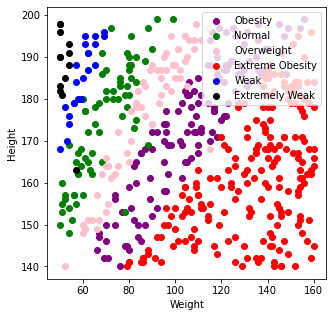

In [10]:
plt.figure(figsize=(5,5)) # 그래프의 가로, 세로 크기를 설정

# 작성된 함수에 따라 라벨과 색상을 입력
myscatter('Obesity','purple')            
myscatter('Normal','green')
myscatter('Overweight','pink')
myscatter('Extreme Obesity','red')
myscatter( 'Weak','blue')
myscatter( 'Extremely Weak','black')

plt.legend(loc='upper right')           # loc: 범례를 표시할 위치를 지정 (우측 상단)
plt.xlabel('Weight')                    # x축 표시
plt.ylabel('Height')                    # y축 표시
plt.show()                              # 그래프를 표시

- 몸무게와 키에 따른 데이터의 분포를 시각적, 직관적으로 확인해볼 수 있음

### 모델링 (모델선택, 학습, 평가) 
- 1. 문제와 정답으로 데이터를 분리
- 2. 훈련세트와 평가세트로 분리
- 3. 모델 생성 및 하이퍼파라미터 조정
- 4. 학습 및 평가 실시

In [13]:
bmi = pd.read_csv('data/bmi_500.csv')

In [14]:
bmi.head()      # 맨위 5개의 행을 출력 -> 가로안에 숫자만큼 출력이됨
                # tail() -> 맨아래 5개

,Gender,Height,Weight,Label
0,Male,174,96,Obesity
1,Male,189,87,Normal
2,Female,185,110,Obesity
3,Female,195,104,Overweight
4,Male,149,61,Overweight


In [16]:
# 문제, 정답 분리
X = bmi.loc[:,'Height':'Weight']
y = bmi.loc[:,'Label']

In [17]:
print(X.shape)
print(y.shape)

(500, 2)
(500,)


In [18]:
# 훈련, 평가 세트 분리

#훈련용 문제 데이터
X_train = X.iloc[:350,:]
# 평가용 문제 데이터
X_test = X.iloc[350:,:]
# 훈련용 정답 데이터
y_train = y.iloc[:350]
# 평가용 정답 데이터
y_test = y.iloc[350:]

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(350, 2)
(150, 2)
(350,)
(150,)


In [23]:
knn_model = KNeighborsClassifier(n_neighbors= 10)

In [24]:
knn_model

KNeighborsClassifier(n_neighbors=10)

In [31]:
knn_model.fit(X_train,y_train) 

KNeighborsClassifier(n_neighbors=10)

In [32]:
pre = knn_model.predict(X_test)
pre

array(['Normal', 'Normal', 'Normal', 'Extreme Obesity', 'Extremely Weak',
       'Obesity', 'Obesity', 'Extreme Obesity', 'Weak', 'Extreme Obesity',
       'Weak', 'Extreme Obesity', 'Extreme Obesity', 'Obesity',
       'Extreme Obesity', 'Extreme Obesity', 'Overweight', 'Obesity',
       'Extreme Obesity', 'Obesity', 'Overweight', 'Extreme Obesity',
       'Weak', 'Normal', 'Obesity', 'Extreme Obesity', 'Extreme Obesity',
       'Extreme Obesity', 'Obesity', 'Overweight', 'Extreme Obesity',
       'Weak', 'Obesity', 'Extreme Obesity', 'Extreme Obesity', 'Normal',
       'Extreme Obesity', 'Obesity', 'Overweight', 'Normal', 'Normal',
       'Normal', 'Normal', 'Overweight', 'Extreme Obesity', 'Overweight',
       'Overweight', 'Extreme Obesity', 'Overweight', 'Extreme Obesity',
       'Overweight', 'Obesity', 'Normal', 'Obesity', 'Obesity',
       'Extreme Obesity', 'Normal', 'Extreme Obesity', 'Extreme Obesity',
       'Extreme Obesity', 'Weak', 'Obesity', 'Extreme Obesity',
       'E

In [35]:
metrics.accuracy_score(pre,y_test)

0.9333333333333333

### 학습된 모델에 내 키와 몸무게를 넣어 확인해보자!

In [34]:
knn_model.predict([[181, 103]])

array(['Obesity'], dtype=object)